## Load the Dataset

In [29]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import model_selection
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
import shap

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
# Load the dataset

df = pd.read_csv('Cleaned_Data.csv')
df.head()

,Location,Price,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
0,KLCC,1250000.0000,2,3.0000,Serviced Residence,1335.0000,Fully Furnished,1,53.0000,24.0000,20.0000,5.0000,813.0000
1,KLCC,2400000.0000,2,2.0000,Serviced Residence,1006.0000,Fully Furnished,0,53.0000,24.0000,20.0000,5.0000,813.0000
2,KLCC,3600000.0000,4,4.0000,Serviced Residence,3897.0000,Partly Furnished,0,53.0000,24.0000,20.0000,5.0000,813.0000
3,KLCC,4280000.0000,3,4.0000,Serviced Residence,2195.0000,Fully Furnished,1,53.0000,24.0000,20.0000,5.0000,813.0000
4,KLCC,2300000.0000,1,2.0000,Serviced Residence,1023.0000,Partly Furnished,0,53.0000,24.0000,20.0000,5.0000,813.0000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44223 entries, 0 to 44222
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           44223 non-null  object 
 1   Price              44223 non-null  float64
 2   Rooms              44223 non-null  int64  
 3   Bathrooms          44223 non-null  float64
 4   Property Type      44223 non-null  object 
 5   Size               44223 non-null  float64
 6   Furnishing         44223 non-null  object 
 7   Store Rooms        44223 non-null  int64  
 8   Places of Worship  44223 non-null  float64
 9   Schools            44223 non-null  float64
 10  Hospitals          44223 non-null  float64
 11  Malls              44223 non-null  float64
 12  Restaurants        44223 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 4.4+ MB


## Feature Extraction

### Encoding

In [4]:
# Select categorical columns

categorical = df.select_dtypes(exclude=[np.number]).columns
print (categorical)

Index(['Location', 'Property Type', 'Furnishing'], dtype='object')


In [5]:
le_location = LabelEncoder()
df['Location'] = le_location.fit_transform(df['Location'])

In [6]:
le_proptype = LabelEncoder()
df['Property Type'] = le_proptype.fit_transform(df['Property Type'])

In [7]:
le_furnishing = LabelEncoder()
df['Furnishing'] = le_furnishing.fit_transform(df['Furnishing'])

### Split and Scale the Dataset

In [9]:
# Shuffle rows

df = shuffle(df, random_state=42)

In [10]:
# Split dataset into features and outcome

DV = 'Price'
x = df.drop(DV, axis=1)
y = df[DV]

In [11]:
# Split into train and test

x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.20,
random_state=42)

In [12]:
# Select all numerical columns except for Price

numerical = ['Rooms', 'Bathrooms', 'Size', 'Store Rooms', 'Places of Worship',\
             'Schools', 'Hospitals', 'Malls', 'Restaurants']

In [13]:
# Scale numerical columns

scaler = MinMaxScaler()
x_train[numerical] = scaler.fit_transform(x_train[numerical])
x_train.head()

,Location,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
36520,0,0.3333,0.3333,2,0.3248,0,0.5000,1.0000,0.5714,0.9130,0.6250,0.7888
1863,32,0.1667,0.1667,6,0.2287,0,0.5000,0.9500,0.7857,0.8696,0.6250,0.8123
18650,25,0.3333,0.3333,7,0.2638,2,0.5000,0.5500,0.7500,0.0435,0.6250,0.5486
43497,60,0.3333,0.1667,6,0.1358,0,0.0000,0.9750,0.6429,0.9130,0.6250,0.8067
34544,14,0.6667,0.6667,5,0.6737,1,1.0000,0.2500,0.2857,0.0435,0.1250,0.0626


In [14]:
x_test[numerical] = scaler.transform(x_test[numerical])
x_test.head()

,Location,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
41944,51,0.5000,0.6667,2,0.7418,0,0.5000,0.5500,0.5357,0.2609,0.3750,0.4447
22395,49,0.3333,0.1667,6,0.1204,2,0.0000,0.8000,0.4643,1.0000,0.2500,0.4391
14960,20,0.5000,0.6667,5,0.8796,2,0.5000,0.1750,0.1429,0.1739,0.1250,0.1553
41012,12,0.3333,0.3333,2,0.4303,1,0.5000,0.5500,0.6071,0.1739,0.5000,0.4732
36204,0,0.3333,0.3333,6,0.1642,0,0.0000,1.0000,0.5714,0.9130,0.6250,0.7888


In [15]:
joblib.dump(scaler, 'scaler.save')

['scaler.save']

## Modelling

### XGBoost

In [41]:
XGB = XGBRegressor(random_state=42)

param_grid = {'nthread':[4], 
              'objective':['reg:squarederror'],
              'learning_rate': [0.03, 0.05, 0.07], 
              'max_depth': [10, 15, 20],
              'min_child_weight': [1, 3, 5],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 300, 500]}

XGB_model = model_selection.GridSearchCV(
estimator=XGB,
param_grid=param_grid,
verbose=True,
n_jobs=-1,
cv=3
)

XGB_model.fit(x_train, y_train)
print(f"Best score: {XGB_model.best_score_}")
print("Best parameters set:")
best_parameters = XGB_model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best score: 0.9018803211613381
Best parameters set:
	colsample_bytree: 0.7
	learning_rate: 0.03
	max_depth: 20
	min_child_weight: 3
	n_estimators: 300
	nthread: 4
	objective: reg:squarederror
	subsample: 0.7


In [16]:
# Build XGBoost model

XGB_model = XGBRegressor(
    random_state=42,
    colsample_bytree=0.7,
    learning_rate=0.03,
    max_depth=20,
    min_child_weight=3,
    n_estimators=300,
    nthread=4,
    objective='reg:squarederror',
    subsample=0.7
)

XGB_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, nthread=4, num_parallel_tree=None,
             predictor=None, ...)

In [17]:
# Generate predictions

XGB_pred = XGB_model.predict(x_test)
print(XGB_pred[:10])

[3131571.    489288.28 2232439.   1594082.2  1108590.6   587507.7
  463302.03  554740.7  2498093.8   695673.1 ]


In [54]:
# Find metrics
from sklearn import metrics

XGB_metrics = pd.DataFrame ({'Metric':
['MAE',
'MSE',
'RMSE',
'R-Squared'], 'XGBoost':
[metrics.mean_absolute_error(y_test, XGB_pred),
metrics.mean_squared_error (y_test, XGB_pred),
np.sqrt (metrics.mean_squared_error (y_test, XGB_pred)),
metrics.explained_variance_score (y_test, XGB_pred)]})
XGB_metrics

,Metric,XGBoost
0,MAE,149333.6267
1,MSE,96422484087.3409
2,RMSE,310519.7000
3,R-Squared,0.9109


In [48]:
from sklearn import metrics

model = XGBRegressor()
model.fit(x_train, y_train)
pred = model.predict(x_test)
metrics = pd.DataFrame ({'Metric':
['MAE',
'MSE',
'RMSE',
'R-Squared'], 'XGBoost':
[metrics.mean_absolute_error(y_test, pred),
metrics.mean_squared_error (y_test, pred),
np.sqrt (metrics.mean_squared_error (y_test, pred)),
metrics.explained_variance_score (y_test, pred)]})
print(metrics)

      Metric           XGBoost
0        MAE       196629.9185
1        MSE 124185749632.9128
2       RMSE       352399.9853
3  R-Squared            0.8852


### Random Forest

In [50]:
# Grid Search for Random Forest

RF = RandomForestRegressor(random_state=42)

param_grid = {
"n_estimators": [200, 500, 1000],
'max_features': [4, 7, 10],
"max_depth": [25, 50, 100],
'min_samples_leaf': [1, 3],
'min_samples_split': [5, 10]
}

RF_model = model_selection.GridSearchCV(
estimator=RF,
param_grid=param_grid,
verbose=10,
n_jobs=-1,
cv=3
)

RF_model.fit(x_train, y_train)
print(f"Best score: {RF_model.best_score_}")
print("Best parameters set:")
best_parameters = RF_model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best score: 0.8938729880840653
Best parameters set:
	max_depth: 50
	max_features: 10
	min_samples_leaf: 1
	min_samples_split: 5
	n_estimators: 200


In [19]:
# Build Random Forest model

RF_model = RandomForestRegressor(
    random_state=42,
    max_depth=50,
    max_features=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200
)
RF_model.fit(x_train,y_train)

RandomForestRegressor(max_depth=50, max_features=10, min_samples_split=5,
                      n_estimators=200, random_state=42)

In [20]:
# Generate predictions

RF_pred = RF_model.predict(x_test)
print(RF_pred[:10])

[3162725.61199495  492670.91558001 2737886.19365873 1595226.62380952
 1066836.03690476  619535.23015873  472183.48484848  569346.21799034
 2485730.72689123  652915.97998052]


In [52]:
# Find metrics
from sklearn import metrics

RF_metrics = pd.DataFrame ({'Metric':
['MAE',
'MSE',
'RMSE',
'R-Squared'], 'Random Forest':
[metrics.mean_absolute_error(y_test, RF_pred),
metrics.mean_squared_error (y_test, RF_pred),
np.sqrt (metrics.mean_squared_error (y_test, RF_pred)),
metrics.explained_variance_score (y_test, RF_pred)]}).round(3)
RF_metrics

,Metric,Random Forest
0,MAE,153912.1050
1,MSE,105087480164.8240
2,RMSE,324171.9920
3,R-Squared,0.9030


In [54]:
from sklearn import metrics

a = RandomForestRegressor(random_state=42)
a.fit(x_train, y_train)
b = a.predict(x_test)
c = pd.DataFrame ({'Metric':
['MAE',
'MSE',
'RMSE',
'R-Squared'], 'Value':
[metrics.mean_absolute_error (y_test, b),
metrics.mean_squared_error (y_test, b),
np.sqrt (metrics.mean_squared_error (y_test, b)),
metrics.explained_variance_score (y_test, b)]}).round(3)
print(c)

      Metric             Value
0        MAE       154756.0170
1        MSE 111541987810.6820
2       RMSE       333979.0230
3  R-Squared            0.8970


In [82]:
# Set the color palette to 'rocket'
rocket_colors = sns.color_palette('rocket')

# Select the color at index 4
col1 = rocket_colors[5]
col2 = rocket_colors[1]

In [59]:
metrics = pd.merge(XGB_metrics, RF_metrics, on='Metric', how='inner')
metrics.set_index('Metric', inplace=True)
metrics

,XGBoost,Random Forest
Metric,,
MAE,149333.6267,153912.1050
MSE,96422484087.3409,105087480164.8240
RMSE,310519.7000,324171.9920
R-Squared,0.9109,0.9030


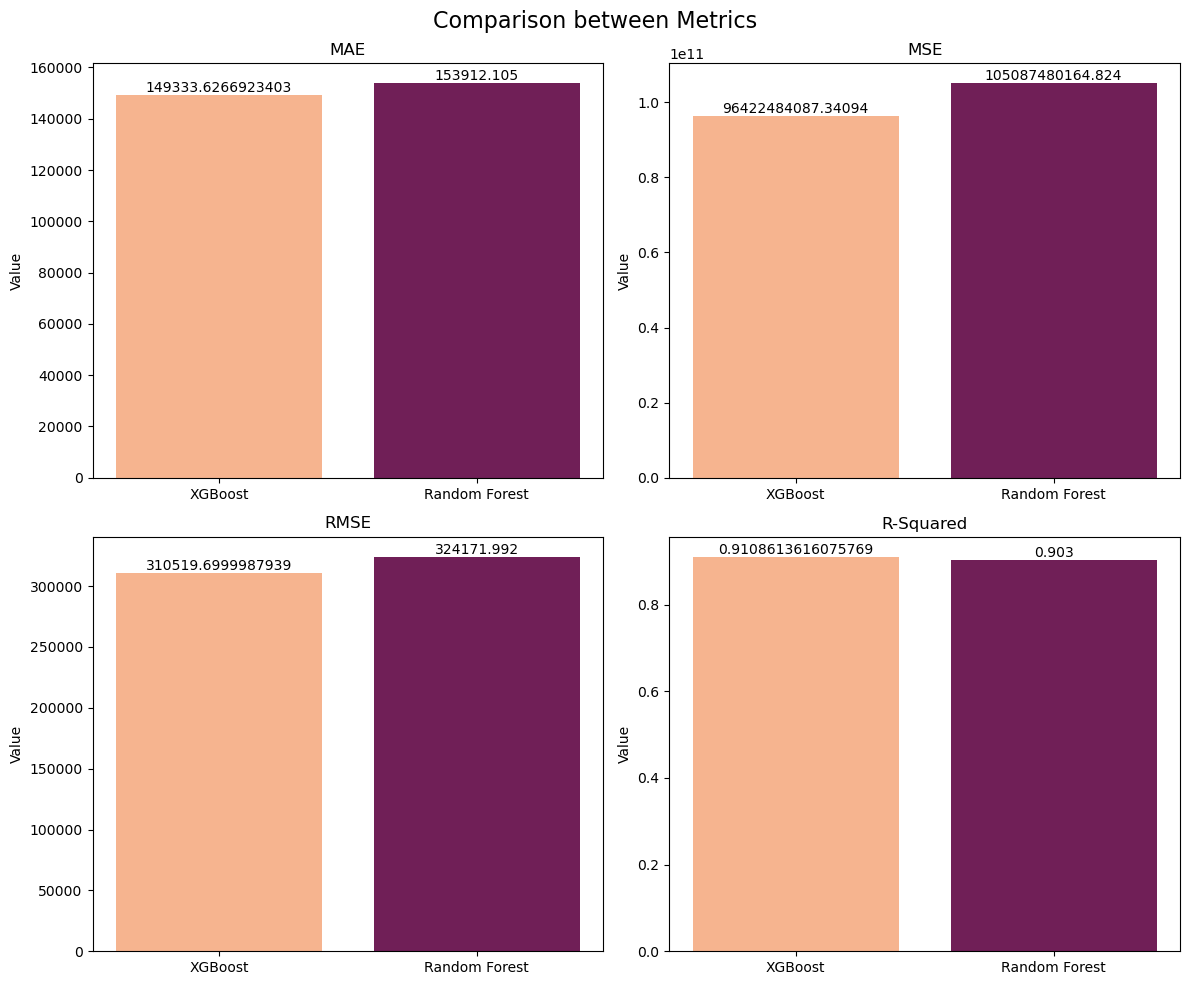

In [83]:
# Plotting the four metrics using subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Set the overall title
fig.suptitle('Comparison between Metrics', fontsize=16)

# Plot MAE
axes[0, 0].bar(metrics.columns, metrics.loc['MAE'], color=[col1, col2])
axes[0, 0].set_title('MAE')
axes[0, 0].set_ylabel('Value')
for i, v in enumerate(metrics.loc['MAE']):
    axes[0, 0].text(i, v, str(v), ha='center', va='bottom')

# Plot MSE
axes[0, 1].bar(metrics.columns, metrics.loc['MSE'], color=[col1, col2])
axes[0, 1].set_title('MSE')
axes[0, 1].set_ylabel('Value')
for i, v in enumerate(metrics.loc['MSE']):
    axes[0, 1].text(i, v, str(v), ha='center', va='bottom')

# Plot RMSE
axes[1, 0].bar(metrics.columns, metrics.loc['RMSE'], color=[col1, col2])
axes[1, 0].set_title('RMSE')
axes[1, 0].set_ylabel('Value')
for i, v in enumerate(metrics.loc['RMSE']):
    axes[1, 0].text(i, v, str(v), ha='center', va='bottom')

# Plot R-Squared
axes[1, 1].bar(metrics.columns, metrics.loc['R-Squared'], color=[col1, col2])
axes[1, 1].set_title('R-Squared')
axes[1, 1].set_ylabel('Value')
for i, v in enumerate(metrics.loc['R-Squared']):
    axes[1, 1].text(i, v, str(v), ha='center', va='bottom')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

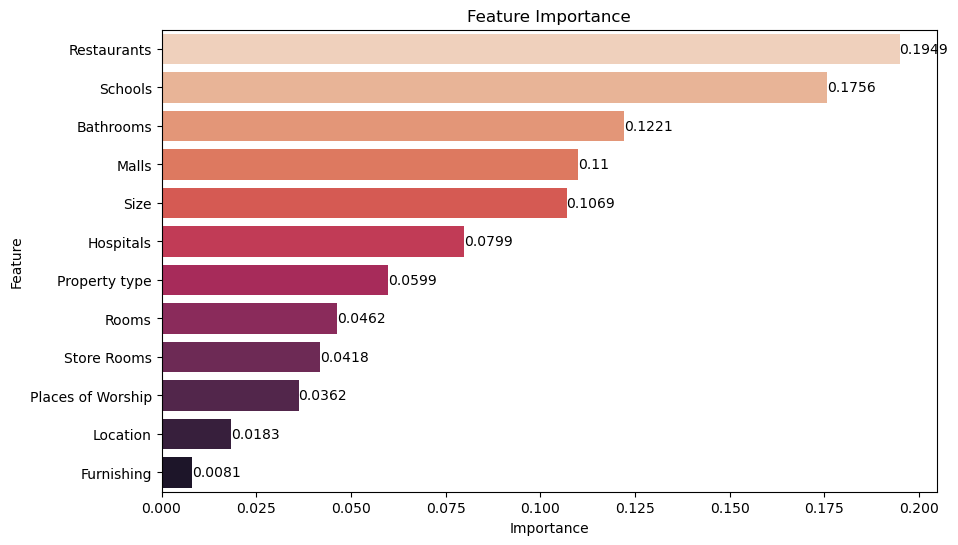

In [84]:
# Get the feature importance scores from the trained XGBoost model
feature_importance = XGB_model.feature_importances_

# Get the names of the columns from your dataset
column_names = ['Location', 'Rooms', 'Bathrooms', 'Property type',\
                'Size', 'Furnishing', 'Store Rooms', 'Places of Worship',\
                'Schools', 'Hospitals', 'Malls', 'Restaurants']

# Create a DataFrame to store the feature importance scores along with the column names
feature_importance_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importance})

# Sort the DataFrame in descending order of importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket_r')
for i, v in enumerate(feature_importance_df['Importance']):
    plt.text(v, i, str(round(v, 4)), va='center')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [26]:
d = [['ampang', 5, 3, 'Condominium', 1900, 'Partly Furnished',\
    0, 53, 24, 20, 5, 813]]

j = pd.DataFrame(d, columns=['Location', 'Rooms', 'Bathrooms', 'Property Type',\
    'Size', 'Furnishing', 'Store Rooms', 'Places of Worship', 'Schools',\
    'Hospitals', 'Malls', 'Restaurants'])
j

,Location,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
0,ampang,5,3,Condominium,1900,Partly Furnished,0,53,24,20,5,813


In [27]:
j[numerical] = scaler.transform(j[numerical])
j

,Location,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
0,ampang,0.6667,0.3333,Condominium,0.3407,Partly Furnished,0.0000,0.9500,0.7857,0.8696,0.6250,0.8123


In [28]:
j['Location'] = le_location.transform(j['Location'])
j['Property Type'] = le_proptype.transform(j['Property Type'])
j['Furnishing'] = le_furnishing.transform(j['Furnishing'])

In [29]:
j

,Location,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
0,0,0.6667,0.3333,2,0.3407,1,0.0000,0.9500,0.7857,0.8696,0.6250,0.8123


In [25]:
XGB_model.predict(j)

NameError: name 'XGB_model' is not defined

In [76]:
data = {
    'model': XGB_model,
    'le_location': le_location,
    'le_proptype': le_proptype,
    'le_furnishing': le_furnishing
}

with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)